## Multimodal Training Sequential

Predict horizon boundaries from full images and geo-temporal infos. Afterwards, predict morphological features and symbol for every horizon

In [1]:
import os
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_  # modifies the tensors in-place (vs clip_grad_norm)
from torch.utils.data import DataLoader
from tqdm import tqdm

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.soil.datasets as bgr_data
import bgr.soil.modelling.general_models as bgr_mod
from bgr.soil.callbacks import EarlyStopping, ModelCheckpoint
from bgr.soil.transforms import VerticalStripeCrop
from bgr.soil.metrics import DepthMarkerLoss
from bgr.soil.utils import pad_tensor

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
path_pictures = "../data/BGR/Profilbilder_no_ruler_no_sky/"
#path_pictures = "../data/BGR/Horizonte/"

### Data Loading

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Horizontsymbol'])
print(len(df.index))
df#.head()

15207
15206


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
col_name = "relevanter Anteil" # try to predict 'relevanter Anteil' first; otherwise, resort to 'stark vereinfacht'
df['Horizontsymbol_relevant'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple, col_name))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_relevant')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


#### Join images and further tables

In [7]:
# Read image dataset and add file path as extra column to df
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float) # for error 'list index out of range', delete @eaDir
#img_files['HorizontID'] = img_files['file'].str.split('.').map(lambda x: x[0][-1]).astype(float) # uncomment only for segmented horizon patches
img_files.head(15)

,file,Point
0,BB_0896_Y_1.JPG,896.0
1,BB_0903_Y_1.JPG,903.0
2,BW_4930_Y_1.JPG,4930.0
3,BW_5183_Y_1.JPG,5183.0
4,BW_5462_Y_1.JPG,5462.0
5,BY_3651_Y_1.JPG,3651.0
6,BY_3934_Y_1.JPG,3934.0
7,BY_3979_Y_1.JPG,3979.0
8,BY_4039_Y_1.JPG,4039.0
9,BY_4302_Y_1.JPG,4302.0


In [8]:
df = pd.merge(df, img_files, how='inner', on=['Point']) # for full images
#df = pd.merge(df, img_files, how='inner', on=['Point', 'HorizontID']) # for patches
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
print(len(df))
df.head(15)

16316


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
5,3.0,1.0,0.0,12.0,I; tbSw-Ah,tSw-Ah,Ls3,10YR 4/2,0.0,C0,h3,Wf6,NaN,SH,7.0,NaN,BB_0661.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
6,3.0,2.0,12.0,30.0,I; tbSw-rAp,tSw-Ap,Ls2,10YR 4/2,0.0,C0,h2,Wf4,NaN,SH,8.0,NaN,BB_0662.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
7,3.0,3.0,30.0,54.0,I; tbrGo-Sw,tGo-Sw,Ls4,2.5Y 5/1,0.0,C0,h1,Wf2,NaN,SH,10.0,NaN,BB_0663.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
8,3.0,4.0,54.0,125.0,I; tbGo-Sd,tGo-Sd,Lu,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,11.0,NaN,BB_0718.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
9,3.0,5.0,125.0,160.0,II; tmGor,tGor,Su3,5Y 5/1,0.0,C0,h1,NaN,NaN,SH,12.0,NaN,BB_0720.0,110.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...


**Note**: When merging with the image dataset, the total dataframe increases in size, because some soil pictures were taken from more than one angle. These are still not duplicates, although the table features are the same for every such image.

In [9]:
# Join with annotator ids
#df_k = pd.read_csv(path_csv_annotator_ids)
#df_k = df_k.rename({'PointID':'Point'},axis=1)
#df_k.head()

In [10]:
#df = pd.merge(df, df_k, how='inner', on='Point')
#len(df)

**Note**: When joining with the annotator ids, the size of df decreases, since we don't have this id for every sample in the df.

In [11]:
# Join with table containing geographical infos
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
print(len(df_loc))
df_loc.head()

3106


,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [12]:
# There are some string artifacts when reading the Standort dataframe. Set them to NaN and remove the rows
df_loc['Point'] = pd.to_numeric(df_loc['Point'], errors='coerce')
df_loc = df_loc.dropna(subset=['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')
len(df)

16316

**Note** Size of df stays the same after merging with df_loc (Points in df_loc are all contained in Points df).

In [13]:
# Decide on which columns to keep for training
keep_columns = ['Point', #'HorizontID',
                'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_relevant',
                #'Horizont_cluster',
                'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung',
                #'max_depth', # not needed for training (and also has mostly NaNs)
                'file',
                #'Aufnehmer', # only when merged with annotators
                'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp',
                #'BodenVarTypSub', # extremely fine grained (> 900 classes) - it offers further specifications of the 'Hauptbodentyp'
                'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']
df = df[keep_columns]
df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
df['ycoord'] = df['ycoord'].astype(float)
df

,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16311,6211.0,70.0,100.0,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16312,6211.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16313,6211.0,100.0,130.0,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72
16314,6211.0,130.0,155.0,Gr,fSms,2.5Y 5/4,1.0,C0,h0,Wf2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,NaN,GG,TSF,T,117.59,87.72


In [14]:
# Profile images only show horizons up to ~1 meter depth
# Note: Filter only necessary when joining table with whole images, not horizon segments
df = df[df['Obergrenze'] < 100]
len(df)

13621

#### Imputation and label simplification

In [15]:
# Replace some of the missing values with recommendations from geology
df['Steine'] = df['Steine'].fillna(0.0)
df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
df['Durchwurzelung'] = df['Durchwurzelung'].str.split(',').str[0] # Some values have double labels; only keep the first one
df['Exposition'] = df['Exposition'].replace(['0', '---'], 'KE') # KE = Keine
df['Woelbung'] = df['Woelbung'].replace(['0', '---'], 'GG') # GG = gestreckt-gestreckt (the most common terrain curvature)
df['Reliefformtyp'] = df['Reliefformtyp'].replace(['0', '---'], 'H') # h = Hang (most common relief type)
df['LageImRelief'] = df['LageImRelief'].replace('0', 'Z') # Z = Zentrallage (most common positioning)
df['Karbonat'] = df['Karbonat'].replace('---', 'C0')
df['GrundwaStufe'] = df['GrundwaStufe'].replace('---', '0')
df.loc[df['Exposition'].isna() & (df['Neigung'] == 'N0'), 'Exposition'] = 'KE' # NaN-Exposition should be 'KE', when Neigung is N0 (there will still be some other NaNs in Exposition

/tmp/ipykernel_1538593/3689211154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Steine'] = df['Steine'].fillna(0.0)
/tmp/ipykernel_1538593/3689211154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Durchwurzelung'] = df['Durchwurzelung'].fillna('Wf0')
/tmp/ipykernel_1538593/3689211154.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [16]:
# Remove 'f' and 'g' from the 'Durchwurzelung' column (f = fein, g = grob)
df['Durchwurzelung'] = df['Durchwurzelung'].str.replace('f|g', '', regex=True)

/tmp/ipykernel_1538593/3406616615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Durchwurzelung'] = df['Durchwurzelung'].str.replace('f|g', '', regex=True)


In [17]:
# Remove decimals and dots from the 'Karbonat', 'GrundwaStufe' and 'Neigung' columns
# The labels with decimals are just finer characterizations of the parent labels without labels
df['Karbonat'] = df['Karbonat'].str.replace(r'\.\d+', '', regex=True)
df['GrundwaStufe'] = df['GrundwaStufe'].str.replace(r'\.\d+', '', regex=True)
df['Neigung'] = df['Neigung'].str.replace(r'\.\d+', '', regex=True)

/tmp/ipykernel_1538593/993479382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Karbonat'] = df['Karbonat'].str.replace(r'\.\d+', '', regex=True)
/tmp/ipykernel_1538593/993479382.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GrundwaStufe'] = df['GrundwaStufe'].str.replace(r'\.\d+', '', regex=True)
/tmp/ipykernel_1538593/993479382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [18]:
# Only keep the initial symbol for the relief form types (the subsequent letters are further/finer specifications for that type)
df['Reliefformtyp'] = df['Reliefformtyp'].str[0]

/tmp/ipykernel_1538593/2838819203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reliefformtyp'] = df['Reliefformtyp'].str[0]


In [19]:
# Only keep the main symbol of the soil type (when provided, the 3rd lowercase letter is a finer specification of the main type)
df['Hauptbodentyp'] = df['Hauptbodentyp'].str[:2]

/tmp/ipykernel_1538593/2463675196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hauptbodentyp'] = df['Hauptbodentyp'].str[:2]


#### Features and Labels Encoding

In [20]:
target = 'Horizontsymbol_relevant' #'Horizont_cluster'
num_features   = ['xcoord','ycoord', 'Steine', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Probenahme_Monat', 'Probenahme_Jahr',
                  'Bodenart', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'GrundwaStufe', 'Neigung', #'BodenVarTypSub',
                  'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

In [21]:
counts = df[target].value_counts()
counts

Horizontsymbol_relevant
Ap         2399
Ah          742
Bv          546
Sd          483
Go          403
           ... 
Bsh-Bv        1
ilC+Ap        1
M-Gkso        1
aAh°Gor       1
aAcp2         1
Name: count, Length: 1568, dtype: int64

In [22]:
# If already computed, load the HCE embeddings for the labels (see Label_Graph.ipynb)
with open('./BGR/label_embeddings/all_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)
print(np.shape(emb_dict['embedding']))
emb_dict

(87, 61)


{'ind2label': ['ilC',
  'Ael',
  'Sd',
  'C.',
  'imCv',
  'E.',
  'emC',
  'cC',
  'clC',
  'ilCbtv',
  'aelC',
  'Cv',
  'Bsh',
  'Axh',
  'Bhv',
  'P.',
  'Bvt',
  'Acxh',
  'Gro',
  'iC',
  'tGro',
  'Go',
  'Ap',
  'Gw',
  'Aep',
  'cmC',
  'imC',
  'Ssw',
  'Mc',
  'Hw',
  'Acp',
  'mCv',
  'Bv',
  'Sswd',
  'elC',
  'lC',
  'Aeh',
  'Bhs',
  'Cj',
  'tGr',
  'Axp',
  'bE',
  'Gr',
  'Gkso',
  'Gor',
  'M.',
  'Bsv',
  'Sw',
  'Bt',
  'Bcv',
  'Btv',
  'Hr',
  'Hv',
  'elCc',
  'Bs',
  'R.',
  'tGo',
  'Bh',
  'Ah',
  'Cbtv',
  'Al',
  'Sw-Bv',
  'Bv-ilC',
  'Bt-Sd',
  'Bv-Cv',
  'Sd-ilC',
  'Al-Sw',
  'Al-Bv',
  'M-Go',
  'Ael-Bt',
  'Ah-Bv',
  'Sw-M',
  'Sw-Ap',
  'Bv-Ael',
  'Go-ilC',
  'elC-P',
  'Sd-Bv',
  'Sw-ilC',
  'Al-Bt',
  'Sw-Ah',
  'P-Sd',
  'Sd-lC',
  'Sw-Go',
  'Sw-Bt',
  'Sd-Btv',
  'Bv-elC',
  'M-Gro'],
 'label2ind': {'ilC': 0,
  'Ael': 1,
  'Sd': 2,
  'C.': 3,
  'imCv': 4,
  'E.': 5,
  'emC': 6,
  'cC': 7,
  'clC': 8,
  'ilCbtv': 9,
  'aelC': 10,
  'Cv': 11,
  '

In [23]:
# For HCE: create separate dict where labels made out only of main symbols are stripped of the full stop '.'
# Note: We will use the label indexes from the embedding dictionary instead of a new sparse one-hot encoding to ease access to the embedding vectors during training via the original indexes from the emb_dict
dict_mapping = {}
for key, value in emb_dict['label2ind'].items():
    dict_mapping[key.strip('.')] = value
dict_mapping

{'ilC': 0,
 'Ael': 1,
 'Sd': 2,
 'C': 3,
 'imCv': 4,
 'E': 5,
 'emC': 6,
 'cC': 7,
 'clC': 8,
 'ilCbtv': 9,
 'aelC': 10,
 'Cv': 11,
 'Bsh': 12,
 'Axh': 13,
 'Bhv': 14,
 'P': 15,
 'Bvt': 16,
 'Acxh': 17,
 'Gro': 18,
 'iC': 19,
 'tGro': 20,
 'Go': 21,
 'Ap': 22,
 'Gw': 23,
 'Aep': 24,
 'cmC': 25,
 'imC': 26,
 'Ssw': 27,
 'Mc': 28,
 'Hw': 29,
 'Acp': 30,
 'mCv': 31,
 'Bv': 32,
 'Sswd': 33,
 'elC': 34,
 'lC': 35,
 'Aeh': 36,
 'Bhs': 37,
 'Cj': 38,
 'tGr': 39,
 'Axp': 40,
 'bE': 41,
 'Gr': 42,
 'Gkso': 43,
 'Gor': 44,
 'M': 45,
 'Bsv': 46,
 'Sw': 47,
 'Bt': 48,
 'Bcv': 49,
 'Btv': 50,
 'Hr': 51,
 'Hv': 52,
 'elCc': 53,
 'Bs': 54,
 'R': 55,
 'tGo': 56,
 'Bh': 57,
 'Ah': 58,
 'Cbtv': 59,
 'Al': 60,
 'Sw-Bv': 61,
 'Bv-ilC': 62,
 'Bt-Sd': 63,
 'Bv-Cv': 64,
 'Sd-ilC': 65,
 'Al-Sw': 66,
 'Al-Bv': 67,
 'M-Go': 68,
 'Ael-Bt': 69,
 'Ah-Bv': 70,
 'Sw-M': 71,
 'Sw-Ap': 72,
 'Bv-Ael': 73,
 'Go-ilC': 74,
 'elC-P': 75,
 'Sd-Bv': 76,
 'Sw-ilC': 77,
 'Al-Bt': 78,
 'Sw-Ah': 79,
 'P-Sd': 80,
 'Sd-lC': 81,
 '

In [24]:
# Replace '+' with '-' in the target column (see Label_Graph.ipynb)
df[target] = df[target].str.replace('+', '-', regex=False)
df[target] = df[target].str.replace('°', '-', regex=False) # also these, so that there is only one type of mixtures (the minus-mixture)
# Remove trailing numbers from the labels in the target column (they only account for how often the horizon is seen in the same picture)
df[target] = df[target].str.replace(r'\d+$', '', regex=True)

/tmp/ipykernel_1538593/1744044841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].str.replace('+', '-', regex=False)
/tmp/ipykernel_1538593/1744044841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].str.replace('°', '-', regex=False) # also these, so that there is only one type of mixtures (the minus-mixture)
/tmp/ipykernel_1538593/1744044841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [25]:
# Map rare labels to frequent labels via Levenshtein distance
# Any better ideas? Sometimes the mapping is not very faithful to geological meaning
from jellyfish import levenshtein_distance as ld
rare_labels_mapping = {}
list_dict_mapping = list(dict_mapping.keys())
for lab in df[target].unique():
    if lab in list_dict_mapping:
        rare_labels_mapping[lab] = lab # for applying the map later in the df, we need the identity mappings as well
    else:
        similarities = [ld(lab, freq_lab) for freq_lab in list_dict_mapping]
        best_match = list_dict_mapping[np.argmin(similarities)]
        rare_labels_mapping[lab] = best_match
rare_labels_mapping

{'Ap': 'Ap',
 'E': 'E',
 'Bv': 'Bv',
 'Bv-ilC': 'Bv-ilC',
 'ilC': 'ilC',
 'tSw-Ah': 'Sw-Ah',
 'tSw-Ap': 'Sw-Ap',
 'tGo-Sw': 'tGo',
 'tGo-Sd': 'tGo',
 'Sw-tAp': 'Sw-Ap',
 'tSq': 'Sd',
 'tGro': 'tGro',
 'Aeh': 'Aeh',
 'Aep': 'Aep',
 'oCv': 'Cv',
 'fOh': 'Bsh',
 'Ae': 'Ael',
 'Bsh-Go': 'Bsh',
 'Bs-Go': 'M-Go',
 'R-Ah': 'Ah',
 'R-Gso-Gr': 'Gor',
 'R-Gr-Gso': 'M-Gro',
 'R-Go-Gso': 'Gkso',
 'tbSq': 'Sd',
 'tGor': 'tGr',
 'tAp-Go': 'tGo',
 'Ah-ilCv': 'Bv-ilC',
 'Aeh-Go': 'Aeh',
 'Bs-Gw': 'Bsh',
 'Go-Bhs': 'Bhs',
 'Go-Ap': 'Sw-Ap',
 'Go': 'Go',
 'Gor': 'Gor',
 'Gr': 'Gr',
 'Gw': 'Gw',
 'ilC-Bsh-Bs': 'ilC',
 'Bhs-ilC': 'Bv-ilC',
 'M': 'M',
 'tAp': 'Ap',
 'tGo': 'tGo',
 'Hw': 'Hw',
 'fnHr': 'Hr',
 'tGo-Ap': 'tGo',
 'Gro': 'Gro',
 'Bh-Gw': 'Bhv',
 'Bhs-Bs': 'Bhs',
 'Bhs-Go': 'Bhs',
 'Bhs': 'Bhs',
 'Sw-Bs': 'Sw-Bv',
 'Sd': 'Sd',
 'Sw': 'Sw',
 'Ap-Al': 'Ael',
 'Bt-Sd': 'Bt-Sd',
 'Al-Sw': 'Al-Sw',
 'Ah': 'Ah',
 'Swd': 'Sd',
 'Bh-Aeh': 'Bv-Ael',
 'Bsh': 'Bsh',
 'Bs': 'Bs',
 'Bbs-ilCv': 'Bv-ilC',
 'Bb

In [26]:
len(rare_labels_mapping)
# ToDo: manually correct the weird mappings
# Note: maybe use a second string distance to decide the winner, in case of a tie?

1218

In [27]:
# Map rare labels onto frequent labels
df[target] = df[target].map(rare_labels_mapping)
df

/tmp/ipykernel_1538593/3489057721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].map(rare_labels_mapping)


,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,W4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,E,Sl2,10YR 3/3,3.0,C0,h2,W3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,W3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,W2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,ilC,mSfs,10YR 7/4,1.0,C0,h0,W0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,6211.0,27.0,50.0,Bhs,fSms,5YR 3/2,1.0,C0,h2,W3,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,KE,GG,T,T,117.59,87.72
16308,6211.0,50.0,70.0,Bsh,fSms,5YR 4/3,1.0,C0,h1,W2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,KE,GG,T,T,117.59,87.72
16309,6211.0,50.0,70.0,Bsh,fSms,5YR 4/3,1.0,C0,h1,W2,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,KE,GG,T,T,117.59,87.72
16310,6211.0,70.0,100.0,Go-ilC,fSms,7.5YR 5/4,1.0,C0,h1,W6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,6,2012,522076.9633,5930456.114,Elbe-Weser-Dreieck / sandige Böden,G,0,PP,GWS4,110.0,0.0,0.0,N0,KE,GG,T,T,117.59,87.72


In [28]:
# One-hot encoding of the target column
#bgr_data.encode_categorical_columns(df, target) # for standard one-hot vectors of the targets
df[target] = df[target].map(dict_mapping) # in conjunction with HCEs
df[target] = df[target].astype(int)
df.head(5)

/tmp/ipykernel_1538593/1051670463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].map(dict_mapping) # in conjunction with HCEs
/tmp/ipykernel_1538593/1051670463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].astype(int)


,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,22,Sl2,7.5YR 3/2,3.0,C0,h3,W4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
1,2.0,28.0,54.0,5,Sl2,10YR 3/3,3.0,C0,h2,W3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
2,2.0,54.0,68.0,32,Sl2,7.5YR 4/3,10.0,C0,h1,W3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
3,2.0,68.0,96.0,62,fSms,7.5YR 6/4,1.0,C0,h0,W2,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19
4,2.0,96.0,201.0,0,mSfs,10YR 7/4,1.0,C0,h0,W0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,0,200.0,0.0,0.0,N0,KE,GG,V,Z,81.89,54.19


In [29]:
# Encode categorical features (NaNs are left NaNs)
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,22,3.0,24.0,3.0,0,1.0,4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
1,2.0,28.0,54.0,5,3.0,0.0,3.0,0,3.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
2,2.0,54.0,68.0,32,3.0,20.0,10.0,0,2.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
3,2.0,68.0,96.0,62,8.0,72.0,1.0,0,0.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
4,2.0,96.0,201.0,0,7.0,37.0,1.0,0,0.0,0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,6211.0,27.0,50.0,37,8.0,68.0,1.0,0,3.0,3,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16308,6211.0,50.0,70.0,12,8.0,38.0,1.0,0,2.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16309,6211.0,50.0,70.0,12,8.0,38.0,1.0,0,2.0,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16310,6211.0,70.0,100.0,74,8.0,19.0,1.0,0,2.0,6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72


In [30]:
# Some columns still have NaNs
# For now, we are replacing the missing values with the column medians
# Any better ideas? In particular the column GrundwaStand has quite a few missing entries...
df.info()
df = df.fillna(df.median(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
Index: 13621 entries, 0 to 16311
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Point                    13621 non-null  float64
 1   Obergrenze               13621 non-null  float64
 2   Untergrenze              13621 non-null  float64
 3   Horizontsymbol_relevant  13621 non-null  int64  
 4   Bodenart                 13589 non-null  float64
 5   Bodenfarbe               13572 non-null  float64
 6   Steine                   13621 non-null  float64
 7   Karbonat                 13621 non-null  int64  
 8   Humusgehaltsklasse       13615 non-null  float64
 9   Durchwurzelung           13621 non-null  int64  
 10  file                     13621 non-null  object 
 11  Probenahme_Monat         13621 non-null  int64  
 12  Probenahme_Jahr          13621 non-null  int64  
 13  xcoord                   13621 non-null  float64
 14  ycoord                   13

In [31]:
# Turn categorical tabulars into ints (necessary for the split below)
df = df.astype({'Bodenart': int, 'Bodenfarbe': int, 'Humusgehaltsklasse': int})

In [32]:
# Normalize stones for better convergence in the MSE loss below
df['Steine'] = df['Steine']/df['Steine'].max() # max is 100
df

,Point,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,file,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,0.0,28.0,22,3,24,0.03,0,1,4,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
1,2.0,28.0,54.0,5,3,0,0.03,0,3,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
2,2.0,54.0,68.0,32,3,20,0.10,0,2,3,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
3,2.0,68.0,96.0,62,8,72,0.01,0,0,1,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
4,2.0,96.0,201.0,0,7,37,0.01,0,0,0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,3,4,462216.1283,6079359.775,37,0,0,15,0.0,200.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,81.89,54.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16307,6211.0,27.0,50.0,37,8,68,0.01,0,3,3,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16308,6211.0,50.0,70.0,12,8,38,0.01,0,2,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16309,6211.0,50.0,70.0,12,8,38,0.01,0,2,1,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72
16310,6211.0,70.0,100.0,74,8,19,0.01,0,2,6,../data/BGR/Profilbilder_no_ruler_no_sky/NI_62...,10,0,522076.9633,5930456.114,15,1,0,7,1.0,110.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,117.59,87.72


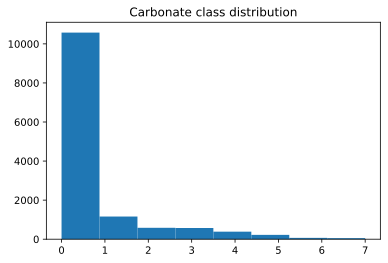

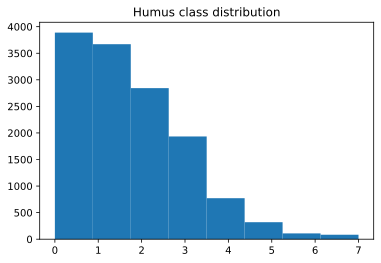

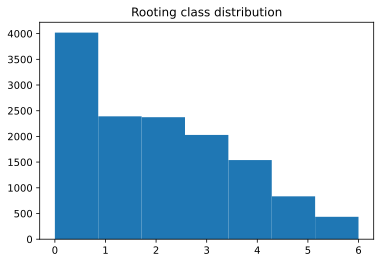

In [33]:
plt.title('Carbonate class distribution')
plt.hist(df['Karbonat'], bins=len(df['Karbonat'].unique()))
plt.show()
plt.title('Humus class distribution')
plt.hist(df['Humusgehaltsklasse'], bins=len(df['Humusgehaltsklasse'].unique()))
plt.show()
plt.title('Rooting class distribution')
plt.hist(df['Durchwurzelung'], bins=len(df['Durchwurzelung'].unique()))
plt.show()

In [34]:
# Used for constructing the tabular predictors in the general model
# For every tabular feature name, specify the output dimension and if it's a classification task
# ToDo: can the classes for soil type and color be clustered further? There's a lot of them :^)
tabular_predictors_dict = {
    #'Soil_Type_Predictor':  {'output_dim': len(df['Bodenart'].unique()),           'classification': True},
    #'Soil_Color_Predictor': {'output_dim': len(df['Bodenfarbe'].unique()),         'classification': True},
    'Stones_Predictor':     {'output_dim': 1,                                      'classification': False},
    'Carbonate_Predictor':  {'output_dim': len(df['Karbonat'].unique()),           'classification': True},
    'Humus_Predictor':      {'output_dim': len(df['Humusgehaltsklasse'].unique()), 'classification': True},
    'Rooting_Predictor':    {'output_dim': len(df['Durchwurzelung'].unique()),     'classification': True}
}
tabular_predictors_dict

{'Stones_Predictor': {'output_dim': 1, 'classification': False},
 'Carbonate_Predictor': {'output_dim': 8, 'classification': True},
 'Humus_Predictor': {'output_dim': 8, 'classification': True},
 'Rooting_Predictor': {'output_dim': 7, 'classification': True}}

In [35]:
len(df['file'].unique()) # number of unique images

3347

### Training

In [36]:
# Split variables into different categories according to their roles in the sequential training
soil_infos = ['Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung']#, 'max_depth', 'HorizontID']

geotemp_img_infos = [#'Point',
                     'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                     'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'GrundwaStufe', 'GrundwaStand', #'BodenVarTypSub',
                     'Moormaechtigkeit', 'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp',
                     'LageImRelief', 'KV_0_30', 'KV_30_100',
                     'file']

depth_markers = ['Obergrenze', 'Untergrenze']

# horizon symbols already in 'target' (see above)

In [37]:
# The dataframe has one row per horizon
# For sequential training, make it one row per full image (the depth markers and the morphological features will be stored as lists and used later as ground truth in training)
df = df.groupby('file', as_index=False).agg({     # Group by images, not by Point, since there are sometimes several images (different angles) for the same Point
    **{gt: 'first' for gt in geotemp_img_infos},  # Take the first value (all are the same for each image, including the image path)
    'Untergrenze': list,                          # Combine depth markers into a list (only lower bound Untergrenze actually needed)
    **{st: list for st in soil_infos},            # Combine tabular features into lists (in the order of the horizons top to bottom)
    target: list
}).reset_index()
#geotemp_img_infos = ['index'] + geotemp_img_infos # Add the new index column
                                                  # Used only for accessing the depths, morphological features and horizon labels from the dataframe
                                                  # (they have different shapes and cannot be stacked in tensor batches)
df

,index,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100,file,Untergrenze,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Horizontsymbol_relevant
0,0,1,7,819021.7488,5941699.083,7,0,0,12,0.0,200.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,38.60,21.42,../data/BGR/Profilbilder_no_ruler_no_sky/BB_05...,"[30.0, 38.0, 50.0, 200.0]","[3, 3, 10, 12]","[1, 1, 10, 5]","[0.02, 0.02, 0.04, 0.04]","[0, 0, 0, 0]","[3, 3, 0, 0]","[3, 3, 1, 2]","[22, 22, 73, 76]"
1,1,1,6,819307.3864,5935183.595,7,0,0,11,0.0,200.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,34.91,11.67,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[29.0, 40.0, 54.0, 60.0, 80.0, 201.0]","[11, 11, 6, 10, 3, 21]","[4, 5, 29, 30, 42, 75]","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03]","[2, 0, 2, 1, 1, 1]","[1, 2, 2, 2, 2, 0]","[4, 3, 1, 1, 1, 0]","[22, 65, 65, 81, 81, 81]"
2,2,8,6,826424.5503,5932240.596,7,0,0,10,0.0,200.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,42.21,34.56,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[28.0, 50.0, 74.0, 110.0]","[10, 11, 11, 11]","[0, 0, 3, 3]","[0.04, 0.04, 0.04, 0.04]","[0, 0, 1, 1]","[1, 3, 2, 0]","[4, 3, 3, 1]","[40, 13, 34, 34]"
3,3,4,6,807568.3913,5926533.227,7,0,0,12,0.0,200.0,0.0,0.0,0.0,5.0,2.0,4.0,3.0,37.39,13.22,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[30.0, 47.0, 73.0, 102.0]","[2, 2, 3, 3]","[0, 10, 13, 16]","[0.04, 0.04, 0.02, 0.02]","[0, 0, 0, 0]","[1, 2, 0, 0]","[3, 1, 1, 2]","[22, 1, 69, 78]"
4,4,1,6,818608.7036,5925050.271,7,0,0,8,2.0,200.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,48.47,16.43,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[33.0, 43.0, 71.0, 88.0, 100.0]","[28, 7, 2, 20, 10]","[0, 15, 54, 44, 14]","[0.01, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0]","[1, 2, 2, 0, 0]","[3, 0, 0, 0, 0]","[22, 0, 65, 0, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,0,6,648389.8108,5588119.501,10,1,0,0,0.0,200.0,0.0,0.0,3.0,7.0,7.0,0.0,3.0,48.82,2.46,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[14.0, 40.0, 60.0, 93.0]","[15, 15, 26, 26]","[6, 5, 53, 53]","[0.6, 0.75, 0.9, 0.9]","[0, 0, 0, 0]","[1, 2, 0, 0]","[5, 3, 1, 2]","[22, 14, 62, 77]"
3343,3343,0,4,688216.3809,5588885.660,10,0,0,0,0.0,200.0,0.0,0.0,1.0,4.0,6.0,0.0,1.0,69.19,23.61,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[34.0, 69.0, 140.0]","[4, 4, 18]","[0, 3, 10]","[0.2, 0.3, 0.25]","[0, 0, 0]","[1, 2, 0]","[5, 3, 1]","[22, 32, 77]"
3344,3344,0,4,701551.6557,5587919.679,10,0,0,0,0.0,200.0,0.0,0.0,3.0,4.0,0.0,0.0,1.0,75.65,9.34,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[20.0, 27.0, 70.0, 100.0]","[15, 15, 15, 26]","[2, 2, 3, 23]","[0.15, 0.25, 0.6, 0.9]","[0, 0, 0, 0]","[1, 1, 2, 0]","[4, 1, 0, 0]","[22, 22, 32, 0]"
3345,3345,3,4,653547.6374,5581353.991,10,0,0,0,0.0,200.0,0.0,0.0,0.0,2.0,0.0,1.0,5.0,61.72,30.69,../data/BGR/Profilbilder_no_ruler_no_sky/TH_35...,"[31.0, 49.0, 71.0, 144.0]","[15, 15, 15, 33]","[1, 7, 5, 16]","[0.05, 0.05, 0.2, 0.25]","[0, 0, 0, 0]","[1, 2, 0, 0]","[3, 2, 2, 2]","[22, 32, 47, 2]"


In [38]:
# Only rows with Obergrenze < 100 were kept. This lead to some Untergrenze values still being above 100.
# Round these down to 100 for a correct loss calculation.
# Also normalize labels to interval [0.0, 1.0] for faster convergence and stability.

df['Untergrenze'] = df['Untergrenze'].apply(bgr_data.normalize_df_list)
df

,index,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100,file,Untergrenze,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Horizontsymbol_relevant
0,0,1,7,819021.7488,5941699.083,7,0,0,12,0.0,200.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,38.60,21.42,../data/BGR/Profilbilder_no_ruler_no_sky/BB_05...,"[0.3, 0.38, 0.5, 1.0]","[3, 3, 10, 12]","[1, 1, 10, 5]","[0.02, 0.02, 0.04, 0.04]","[0, 0, 0, 0]","[3, 3, 0, 0]","[3, 3, 1, 2]","[22, 22, 73, 76]"
1,1,1,6,819307.3864,5935183.595,7,0,0,11,0.0,200.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,34.91,11.67,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[0.29, 0.4, 0.54, 0.6, 0.8, 1.0]","[11, 11, 6, 10, 3, 21]","[4, 5, 29, 30, 42, 75]","[0.03, 0.03, 0.03, 0.03, 0.03, 0.03]","[2, 0, 2, 1, 1, 1]","[1, 2, 2, 2, 2, 0]","[4, 3, 1, 1, 1, 0]","[22, 65, 65, 81, 81, 81]"
2,2,8,6,826424.5503,5932240.596,7,0,0,10,0.0,200.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,42.21,34.56,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[0.28, 0.5, 0.74, 1.0]","[10, 11, 11, 11]","[0, 0, 3, 3]","[0.04, 0.04, 0.04, 0.04]","[0, 0, 1, 1]","[1, 3, 2, 0]","[4, 3, 3, 1]","[40, 13, 34, 34]"
3,3,4,6,807568.3913,5926533.227,7,0,0,12,0.0,200.0,0.0,0.0,0.0,5.0,2.0,4.0,3.0,37.39,13.22,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[0.3, 0.47, 0.73, 1.0]","[2, 2, 3, 3]","[0, 10, 13, 16]","[0.04, 0.04, 0.02, 0.02]","[0, 0, 0, 0]","[1, 2, 0, 0]","[3, 1, 1, 2]","[22, 1, 69, 78]"
4,4,1,6,818608.7036,5925050.271,7,0,0,8,2.0,200.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,48.47,16.43,../data/BGR/Profilbilder_no_ruler_no_sky/BB_06...,"[0.33, 0.43, 0.71, 0.88, 1.0]","[28, 7, 2, 20, 10]","[0, 15, 54, 44, 14]","[0.01, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0]","[1, 2, 2, 0, 0]","[3, 0, 0, 0, 0]","[22, 0, 65, 0, 68]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,0,6,648389.8108,5588119.501,10,1,0,0,0.0,200.0,0.0,0.0,3.0,7.0,7.0,0.0,3.0,48.82,2.46,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[0.14, 0.4, 0.6, 1.0]","[15, 15, 26, 26]","[6, 5, 53, 53]","[0.6, 0.75, 0.9, 0.9]","[0, 0, 0, 0]","[1, 2, 0, 0]","[5, 3, 1, 2]","[22, 14, 62, 77]"
3343,3343,0,4,688216.3809,5588885.660,10,0,0,0,0.0,200.0,0.0,0.0,1.0,4.0,6.0,0.0,1.0,69.19,23.61,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[0.34, 0.69, 1.0]","[4, 4, 18]","[0, 3, 10]","[0.2, 0.3, 0.25]","[0, 0, 0]","[1, 2, 0]","[5, 3, 1]","[22, 32, 77]"
3344,3344,0,4,701551.6557,5587919.679,10,0,0,0,0.0,200.0,0.0,0.0,3.0,4.0,0.0,0.0,1.0,75.65,9.34,../data/BGR/Profilbilder_no_ruler_no_sky/TH_34...,"[0.2, 0.27, 0.7, 1.0]","[15, 15, 15, 26]","[2, 2, 3, 23]","[0.15, 0.25, 0.6, 0.9]","[0, 0, 0, 0]","[1, 1, 2, 0]","[4, 1, 0, 0]","[22, 22, 32, 0]"
3345,3345,3,4,653547.6374,5581353.991,10,0,0,0,0.0,200.0,0.0,0.0,0.0,2.0,0.0,1.0,5.0,61.72,30.69,../data/BGR/Profilbilder_no_ruler_no_sky/TH_35...,"[0.31, 0.49, 0.71, 1.0]","[15, 15, 15, 33]","[1, 7, 5, 16]","[0.05, 0.05, 0.2, 0.25]","[0, 0, 0, 0]","[1, 2, 0, 0]","[3, 2, 2, 2]","[22, 32, 47, 2]"


In [39]:
# Get the lengths of the lists in the 'Untergrenze' column
list_lengths = df['Untergrenze'].apply(len)

min_length = list_lengths.min()
max_length = list_lengths.max()

print(f"Minimum number of horizons: {min_length}")
print(f"Maximum number of horizons: {max_length}")

Minimum number of horizons: 2
Maximum number of horizons: 8


In [40]:
min_length_list = df[df['Untergrenze'].apply(len) == min_length]['Untergrenze'].values[0]
max_length_list = df[df['Untergrenze'].apply(len) == max_length]['Untergrenze'].values[0]
print(f"List with minimum length: {min_length_list}")
print(f"List with maximum length: {max_length_list}")

List with minimum length: [0.32, 1.0]
List with maximum length: [0.13, 0.26, 0.4, 0.58, 0.68, 0.83, 0.98, 1.0]


In [41]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [42]:
# One hot encode the categorical geotemp features for further processing in the MLP
# Note: year and month should be handled differently
geotemp_categ = list(set(categ_features).intersection(set(geotemp_img_infos)))
df = pd.get_dummies(df, columns=geotemp_categ, dtype = int)
# Get new number of geotemp columns
col_geotemp = [c for gt in geotemp_img_infos for c in df.columns if c.startswith(gt)]

In [43]:
# Initialize model
#num_classes = len(df[target].unique()) # for one-hot encoding
#num_classes = emb_dict['embedding'].shape[1] # for HCE (the dim. of final layer in the model should match the dim of the embedded label vectors)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = bgr_mod.HorizonClassifier(geo_temp_input_dim=len(col_geotemp)-1,       # without counting the img path
                                  geo_temp_output_dim=256,
                                  max_seq_len = max_length,                    # fixed from longest list of horizons in one image from dataset
                                  stop_token=1.0,                              # End of Sequence Token at -1 meters
                                  #transformer_dim=128,
                                  #num_transformer_heads=4,
                                  #num_transformer_layers=2,
                                  rnn_hidden_dim=256,
                                  tabular_predictors_dict=tabular_predictors_dict, # for constructing the tabular predictors
                                  tab_pred_device=device)
model.to(device)

HorizonClassifier(
  (image_encoder): ImageEncoder(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

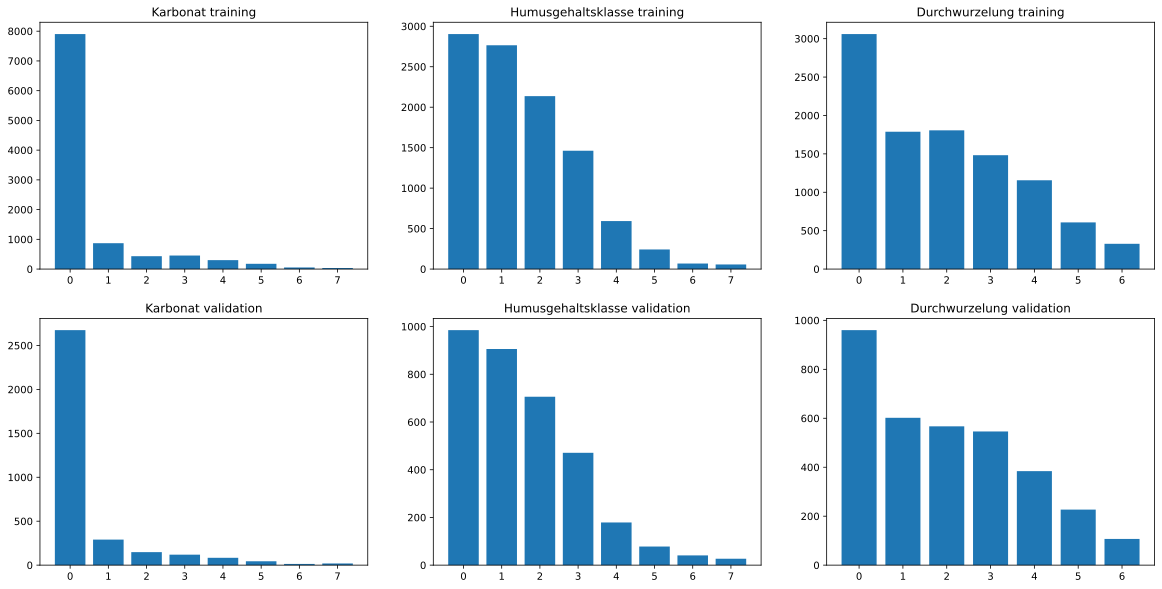

In [44]:
# Split dataset according to distribution of classes in categorical tabular features
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
ml_split = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=2025)
df_tabular_targets = df[soil_infos[3:]] # For now, leave out Bodenart and Bodenfarbe. Also, we don't need to stratify wrt stones (it's numerical)

for train_idx, val_idx in ml_split.split(df, df_tabular_targets):
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]

plt.figure(figsize=(20, 10))
for i, (tab_feature, tab_predictor) in enumerate(zip(list(df_tabular_targets.columns), list(tabular_predictors_dict.keys())[1:])):
    num_cls = tabular_predictors_dict[tab_predictor]['output_dim']
    for _ in range(num_cls):
        counts_train = train_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)
        counts_val   = val_df[tab_feature].explode().value_counts().reindex(np.arange(num_cls), fill_value=0)

    plt.subplot(2, 3, i+1)
    plt.bar(list(range(num_cls)), list(counts_train.values))
    plt.title(tab_feature + ' training')
    plt.subplot(2, 3, i+4)
    plt.bar(list(range(num_cls)), list(counts_val.values))
    plt.title(tab_feature + ' validation')
plt.show()

In [45]:
# Data split
#train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)
#train_df, val_df = train_test_split(df, random_state=2024) # ToDo: not stratified...

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

2510 samples for training.
837 samples for validating.


In [46]:
# Define the image transforms for augmentation
augment = [
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1., 3.))
    VerticalStripeCrop(stripe_width_range=(150, 200)),
    VerticalStripeCrop(stripe_width_range=(150, 200))
]

In [47]:
batch_size = 64
# Create Dataset object with image and tabular features
train_dataset = bgr_data.ImageTabularDataset(dataframe=train_df,
                                             normalize=normalize,
                                             augment=augment,
                                             image_path='file',
                                             label=None, # no label column as input; access it instead via 'index' during training
                                             feature_columns=col_geotemp[:-1]) # without 'file'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,
                          drop_last=True) # any better idea than drop_last? without it, tensors don't get concatenated properly

# Training parameters
#lr, reg = 1e-3, 1e-3
lr, reg = 1e-4, 1e-2
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=reg)

depth_loss = DepthMarkerLoss(lambda_mono=0.0, lambda_div=0.0)
# All the tabular classifiers get a CE loss, all regressors get MSE
soil_losses = {}
for tab_predictor in tabular_predictors_dict:
    if tabular_predictors_dict[tab_predictor]['classification']:
        soil_losses[tab_predictor] = nn.CrossEntropyLoss()
    else:
        soil_losses[tab_predictor] = nn.MSELoss()

# Note: Is MSE better for HCE?
#criterion = nn.CrossEntropyLoss()
#criterion = TopKLoss(k=5)
#criterion = nn.CosineEmbeddingLoss() # for HCE: 1 - cos(prediction, target)

In [49]:
### Callbacks
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.1, min_lr=lr*0.01, verbose=True)
scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy='linear', anneal_epochs=10, swa_lr=lr*0.01)
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True) # looks at val_loss (see callbacks.py)
#checkpoint = ModelCheckpoint(save_path='./BGR/models/lstm_depthmarker.pth', monitor='avg_val_loss', mode='min', verbose=True)
#checkpoint = ModelCheckpoint(save_path='./BGR/models/lstm_depthmarker_mlp_tabular_stones_humus.pth',
#                             monitor='avg_val_loss', mode='min', verbose=True)
checkpoint = ModelCheckpoint(save_path='./BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root.pth',
                             monitor='avg_val_loss', mode='min', verbose=True)

In [50]:
print(f"Training size original: {len(train_dataset.dataframe)}")
print(f"Training size after augmentation: {len(train_dataset)}")

Training size original: 2510
Training size after augmentation: 7530


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0
tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.1902e+05, 5.9417e+06, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 

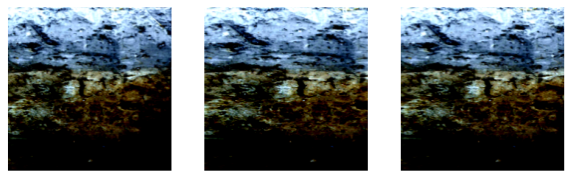

In [51]:
# Check an augmented subset
if augment:
    aug_images = []
    for i in range(len(train_dataset)):
        image, tabular_features = train_dataset[i]
        aug_images.append(image)
        print(f"Image {i}")
        print(tabular_features)
        if i == 2: break

    plt.figure(figsize=(10, 8))
    for i in range(len(aug_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
        plt.axis('off')

In [52]:
val_dataset = bgr_data.ImageTabularDataset(dataframe=val_df,
                                           normalize=normalize,
                                           image_path='file',
                                           label=None,
                                           feature_columns=col_geotemp[:-1]) # without 'file'

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16, drop_last=True)

In [ ]:
"""
for batch in val_loader:
    images, geotemp_features = batch
    images, geotemp_features = images.to(device), geotemp_features.to(device)

    pred_depths, tabular_predictions = model(images=images, geo_temp=geotemp_features, true_depths=None) # use the model's own predicted depths at inference time
    break
tabular_predictions
"""

In [53]:
epochs = 20
lr_history, train_loss_history, val_loss_history = [], [], []
train_depth_loss_history, train_stones_loss_history, train_carb_loss_history, train_humus_loss_history, train_root_loss_history = [], [], [], [], []
val_depth_loss_history, val_stones_loss_history, val_carb_loss_history, val_humus_loss_history, val_root_loss_history = [], [], [], [], []
train_carb_acc_history, train_humus_acc_history, train_root_acc_history = [], [], []
val_carb_acc_history, val_humus_acc_history, val_root_acc_history = [], [], []
num_horizons_train, num_horizons_val = 0, 0
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    model.train() # Important: reset the model in training mode at the beginning of every epoch
    train_depth_loss_total = 0.0
    train_stones_loss_total, train_carb_loss_total, train_humus_loss_total, train_root_loss_total = 0.0, 0.0, 0.0, 0.0
    train_loss_total = 0.0
    train_carb_correct, train_humus_correct, train_root_correct = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, geotemp_features = batch
        images, geotemp_features = images.to(device), geotemp_features.to(device)

        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop

        # Get corresponding true depth markers and morphological features via index column in df (the first value in every row in geotemp)
        # Note: the code accounts for duplicate indexes resulting after the augmentations in the ImageTabularDataset class (is there a better way than duplicating indexes during augmentation?)
        true_depths = []
        true_stones, true_carb, true_humus, true_root = [], [], [], []
        batch_indices = geotemp_features.cpu().numpy()[:, 0]
        for idx in batch_indices:
            true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )
            true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
            true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
            true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
            true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )
        true_stones = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
        true_carb   = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
        true_humus  = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
        true_root   = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)

        # Count num. horizons throughout 1st epoch
        if epoch == 0: num_horizons_train += len(true_stones)

        # Turn list of depths into a padded tensor and also return mask of valid positions
        padded_true_depths = pad_tensor(true_depths,
                                        max_seq_len=model.depth_marker_predictor.max_seq_len,
                                        stop_token=model.depth_marker_predictor.stop_token,
                                        device=device)

        # Predict depth markers (as padded tensors) and morphological features (only pred_stones is a number from regression, the rest are softmax)
        pred_depths, tabular_predictions = model(images=images, geo_temp=geotemp_features,
                                                 true_depths=true_depths) # use ground truth depths during training for concatenation with image-geotemp vector (padded_true_depths needed for LSTMTabular)

        # Compute individual losses, then sum them together for backprop
        train_depth_loss = depth_loss(pred_depths, padded_true_depths)
        train_stones_loss = soil_losses['Stones_Predictor'](tabular_predictions['Stones_Predictor'], true_stones)
        train_carb_loss = soil_losses['Carbonate_Predictor'](tabular_predictions['Carbonate_Predictor'], true_carb)
        train_humus_loss  = soil_losses['Humus_Predictor'](tabular_predictions['Humus_Predictor'], true_humus)
        train_root_loss = soil_losses['Rooting_Predictor'](tabular_predictions['Rooting_Predictor'], true_root)
        train_loss = train_depth_loss + train_stones_loss + train_carb_loss + train_humus_loss + train_root_loss
        # Note: any reason to weight the losses differently?

        train_loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate batch losses to total loss
        train_depth_loss_total += train_depth_loss.item()
        train_stones_loss_total += train_stones_loss.item()
        train_carb_loss_total += train_carb_loss.item()
        train_humus_loss_total += train_humus_loss.item()
        train_root_loss_total += train_root_loss.item()
        train_loss_total += train_loss.item()

        # Calculate accuracies for categorical tabular features
        train_carb_correct += (torch.argmax(tabular_predictions['Carbonate_Predictor'], 1) == true_carb).sum().item()
        train_humus_correct += (torch.argmax(tabular_predictions['Humus_Predictor'], 1) == true_humus).sum().item()
        train_root_correct += (torch.argmax(tabular_predictions['Rooting_Predictor'], 1) == true_root).sum().item()

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Average losses and accuracies at the end of the epoch
    avg_train_depth_loss = train_depth_loss_total / len(train_loader) # divide by number of batches
    avg_train_stones_loss = train_stones_loss_total / len(train_loader)
    avg_train_carb_loss = train_carb_loss_total / len(train_loader)
    avg_train_humus_loss = train_humus_loss_total / len(train_loader)
    avg_train_root_loss = train_root_loss_total / len(train_loader)
    avg_train_loss = train_loss_total / len(train_loader)

    train_carb_acc = train_carb_correct / num_horizons_train
    train_humus_acc = train_humus_correct / num_horizons_train
    train_root_acc = train_root_correct / num_horizons_train

    # Evaluation loop
    model.eval() # Set model in evaluation mode before running inference
    val_depth_loss_total = 0.0
    val_stones_loss_total, val_carb_loss_total, val_humus_loss_total, val_root_loss_total = 0.0, 0.0, 0.0, 0.0
    val_loss_total = 0.0
    val_carb_correct, val_humus_correct, val_root_correct = 0, 0, 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, geotemp_features = batch
            images, geotemp_features = images.to(device), geotemp_features.to(device)

            # Get corresponding true depth markers via index column in df (see training step above)
            true_depths = []
            true_stones, true_carb, true_humus, true_root = [], [], [], []
            batch_indices = geotemp_features.cpu().numpy()[:, 0]
            for idx in batch_indices:
                true_depths.append( df.loc[df['index'] == idx, 'Untergrenze'].values[0] )
                true_stones.append( torch.tensor(df.loc[df['index'] == idx, 'Steine'].values[0]) )
                true_carb.append( torch.tensor(df.loc[df['index'] == idx, 'Karbonat'].values[0]) )
                true_humus.append( torch.tensor(df.loc[df['index'] == idx, 'Humusgehaltsklasse'].values[0]) )
                true_root.append( torch.tensor(df.loc[df['index'] == idx, 'Durchwurzelung'].values[0]) )
            true_stones = torch.stack([item for sublist in true_stones for item in sublist], dim=0).to(device)
            true_carb   = torch.stack([item for sublist in true_carb for item in sublist], dim=0).to(device)
            true_humus  = torch.stack([item for sublist in true_humus for item in sublist], dim=0).to(device)
            true_root   = torch.stack([item for sublist in true_root for item in sublist], dim=0).to(device)

            # Count num. horizons throughout 1st epoch
            if epoch == 0: num_horizons_val += len(true_stones)

            # Turn list of depths into a padded tensor and also return mask of valid positions
            padded_true_depths = pad_tensor(true_depths,
                                            max_seq_len=model.depth_marker_predictor.max_seq_len,
                                            stop_token=model.depth_marker_predictor.stop_token,
                                            device=device)

            # Predict depth markers (as padded tensors) and morphological features
            pred_depths, tabular_predictions = model(images=images, geo_temp=geotemp_features,
                                                     true_depths=true_depths)
            # Note: should we use the model's predicted depths here?
            # But then there can be a mismatch between the number of true tabular labels and the ones that can be predicted...

            # Compute batch losses
            val_depth_loss = depth_loss(pred_depths, padded_true_depths)
            val_stones_loss = soil_losses['Stones_Predictor'](tabular_predictions['Stones_Predictor'], true_stones)
            val_carb_loss = soil_losses['Carbonate_Predictor'](tabular_predictions['Carbonate_Predictor'], true_carb)
            val_humus_loss  = soil_losses['Humus_Predictor'](tabular_predictions['Humus_Predictor'], true_humus)
            val_root_loss = soil_losses['Rooting_Predictor'](tabular_predictions['Rooting_Predictor'], true_root)
            val_loss = val_depth_loss + val_stones_loss + val_carb_loss + val_humus_loss + val_root_loss

            # Add batch losses to total loss
            val_depth_loss_total += val_depth_loss.item()
            val_stones_loss_total += val_stones_loss.item()
            val_carb_loss_total += val_carb_loss.item()
            val_humus_loss_total += val_humus_loss.item()
            val_root_loss_total += val_root_loss.item()
            val_loss_total += val_loss.item()

            # Calculate accuracies for categorical tabular features
            val_carb_correct += (torch.argmax(tabular_predictions['Carbonate_Predictor'], 1) == true_carb).sum().item()
            val_humus_correct += (torch.argmax(tabular_predictions['Humus_Predictor'], 1) == true_humus).sum().item()
            val_root_correct += (torch.argmax(tabular_predictions['Rooting_Predictor'], 1) == true_root).sum().item()

    # Average losses and accuracies at the end of the epoch
    avg_val_depth_loss = val_depth_loss_total / len(val_loader) # divide by number of batches
    avg_val_stones_loss = val_stones_loss_total / len(val_loader)
    avg_val_carb_loss = val_carb_loss_total / len(val_loader)
    avg_val_humus_loss = val_humus_loss_total / len(val_loader)
    avg_val_root_loss = val_root_loss_total / len(val_loader)
    avg_val_loss = val_loss_total / len(val_loader)

    val_carb_acc = val_carb_correct / num_horizons_val
    val_humus_acc = val_humus_correct / num_horizons_val
    val_root_acc = val_root_correct / num_horizons_val

    # Save checkpoint if validation loss is at an optimum
    checkpoint(model, avg_val_loss)
    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    train_depth_loss_history.append(avg_train_depth_loss); val_depth_loss_history.append(avg_val_depth_loss)
    train_stones_loss_history.append(avg_train_stones_loss); val_stones_loss_history.append(avg_val_stones_loss)
    train_carb_loss_history.append(avg_train_carb_loss); val_carb_loss_history.append(avg_val_carb_loss)
    train_humus_loss_history.append(avg_train_humus_loss); val_humus_loss_history.append(avg_val_humus_loss)
    train_root_loss_history.append(avg_train_root_loss); val_root_loss_history.append(avg_val_root_loss)

    train_carb_acc_history.append(train_carb_acc); val_carb_acc_history.append(val_carb_acc)
    train_humus_acc_history.append(train_humus_acc); val_humus_acc_history.append(val_humus_acc)
    train_root_acc_history.append(train_root_acc); val_root_acc_history.append(val_root_acc)

    print(f"Epoch {epoch+1}, Total Training Loss: {avg_train_loss:.4f}")
    print(f"Depth Loss: {avg_train_depth_loss:.4f}")
    print(f"Stones Loss: {avg_train_stones_loss:.4f}")
    print(f"Carb Loss: {avg_train_carb_loss:.4f}, Carb Accuracy: {train_carb_acc:.4f}")
    print(f"Humus Loss: {avg_train_humus_loss:.4f}, Humus Accuracy: {train_humus_acc:.4f}")
    print(f"Root Loss: {avg_train_root_loss:.4f}, Root Accuracy: {train_root_acc:.4f}")
    print(f"\nTotal Validation Loss: {avg_val_loss:.4f}")
    print(f"Depth Loss: {avg_val_depth_loss:.4f}")
    print(f"Stones Loss: {avg_val_stones_loss:.4f}")
    print(f"Carb Loss: {avg_val_carb_loss:.4f}, Carb Accuracy: {val_carb_acc:.4f}")
    print(f"Humus Loss: {avg_val_humus_loss:.4f}, Humus Accuracy: {val_humus_acc:.4f}")
    print(f"Root Loss: {avg_val_root_loss:.4f}, Root Accuracy: {val_root_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/20


/home/tchiaburu/anaconda3/envs/torch_gpu_sam/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model checkpoint saved at './BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root.pth' with avg_val_loss: 24.9314
Epoch 1, Total Training Loss: 4.5184
Depth Loss: 0.0863
Stones Loss: 0.1816
Carb Loss: 1.5680, Carb Accuracy: 0.5228
Humus Loss: 1.3308, Humus Accuracy: 0.5562
Root Loss: 1.3517, Root Accuracy: 0.4971

Total Validation Loss: 24.9314
Depth Loss: 0.0108
Stones Loss: 0.1656
Carb Loss: 1.2935, Carb Accuracy: 0.7968
Humus Loss: 13.0845, Humus Accuracy: 0.2386
Root Loss: 10.3770, Root Accuracy: 0.2751
Current LR: 9.010000000000001e-05
Epoch 2/20


Model checkpoint saved at './BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root.pth' with avg_val_loss: 23.6320
Epoch 2, Total Training Loss: 1.0800
Depth Loss: 0.0090
Stones Loss: 0.0936
Carb Loss: 0.4730, Carb Accuracy: 0.9480
Humus Loss: 0.2423, Humus Accuracy: 0.9537
Root Loss: 0.2621, Root Accuracy: 0.9437

Total Validation Loss: 23.6320
Depth Loss: 0.0095
Stones Loss: 0.0089
Carb Loss: 2.0134, Carb Accuracy: 0.8040
Humus Loss: 11.5800, Humus Accuracy: 0.2603
Root Loss: 10.0203, Root Accuracy: 0.3213
Current LR: 8.020000000000001e-05
Epoch 3/20


Model checkpoint saved at './BGR/models/lstm_depthmarker_resnet_seg_mlp_tabular_stones_carb_humus_root.pth' with avg_val_loss: 20.5768
Epoch 3, Total Training Loss: 0.3562
Depth Loss: 0.0062
Stones Loss: 0.0399
Carb Loss: 0.1477, Carb Accuracy: 0.9940
Humus Loss: 0.0813, Humus Accuracy: 0.9913
Root Loss: 0.0809, Root Accuracy: 0.9910

Total Validation Loss: 20.5768
Depth Loss: 0.0069
Stones Loss: 0.0088
Carb Loss: 2.4878, Carb Accuracy: 0.7467
Humus Loss: 8.4164, Humus Accuracy: 0.2918
Root Loss: 9.6569, Root Accuracy: 0.3591
Current LR: 7.029999999999999e-05
Epoch 4/20


Epoch 4, Total Training Loss: 0.1671
Depth Loss: 0.0021
Stones Loss: 0.0188
Carb Loss: 0.0706, Carb Accuracy: 0.9984
Humus Loss: 0.0384, Humus Accuracy: 0.9971
Root Loss: 0.0373, Root Accuracy: 0.9972

Total Validation Loss: 32.8700
Depth Loss: 0.0040
Stones Loss: 0.0061
Carb Loss: 3.1580, Carb Accuracy: 0.7171
Humus Loss: 15.2045, Humus Accuracy: 0.2010
Root Loss: 14.4975, Root Accuracy: 0.2600
Current LR: 6.04e-05
EarlyStopping: No improvement for 1 epochs.
Epoch 5/20


Epoch 5, Total Training Loss: 0.0951
Depth Loss: 0.0005
Stones Loss: 0.0097
Carb Loss: 0.0399, Carb Accuracy: 0.9995
Humus Loss: 0.0229, Humus Accuracy: 0.9988
Root Loss: 0.0220, Root Accuracy: 0.9990

Total Validation Loss: 25.7559
Depth Loss: 0.0040
Stones Loss: 0.0016
Carb Loss: 2.8198, Carb Accuracy: 0.7639
Humus Loss: 11.4702, Humus Accuracy: 0.2867
Root Loss: 11.4603, Root Accuracy: 0.3408
Current LR: 5.0499999999999994e-05
EarlyStopping: No improvement for 2 epochs.
Epoch 6/20


Epoch 6, Total Training Loss: 0.0625
Depth Loss: 0.0004
Stones Loss: 0.0057
Carb Loss: 0.0275, Carb Accuracy: 0.9999
Humus Loss: 0.0149, Humus Accuracy: 0.9996
Root Loss: 0.0141, Root Accuracy: 0.9998

Total Validation Loss: 28.8963
Depth Loss: 0.0040
Stones Loss: 0.0015
Carb Loss: 3.1298, Carb Accuracy: 0.7511
Humus Loss: 13.0034, Humus Accuracy: 0.2684
Root Loss: 12.7576, Root Accuracy: 0.3188
Current LR: 4.06e-05
EarlyStopping: No improvement for 3 epochs.
Epoch 7/20


Epoch 7, Total Training Loss: 0.0465
Depth Loss: 0.0003
Stones Loss: 0.0039
Carb Loss: 0.0207, Carb Accuracy: 1.0000
Humus Loss: 0.0109, Humus Accuracy: 0.9999
Root Loss: 0.0108, Root Accuracy: 0.9999

Total Validation Loss: 26.5831
Depth Loss: 0.0039
Stones Loss: 0.0022
Carb Loss: 2.7996, Carb Accuracy: 0.7508
Humus Loss: 12.2258, Humus Accuracy: 0.2867
Root Loss: 11.5517, Root Accuracy: 0.3318
Current LR: 3.07e-05
EarlyStopping: No improvement for 4 epochs.
Epoch 8/20


Epoch 8, Total Training Loss: 0.0388
Depth Loss: 0.0002
Stones Loss: 0.0030
Carb Loss: 0.0173, Carb Accuracy: 0.9999
Humus Loss: 0.0093, Humus Accuracy: 0.9997
Root Loss: 0.0090, Root Accuracy: 0.9998

Total Validation Loss: 27.4581
Depth Loss: 0.0040
Stones Loss: 0.0022
Carb Loss: 3.0963, Carb Accuracy: 0.7787
Humus Loss: 12.2689, Humus Accuracy: 0.3177
Root Loss: 12.0868, Root Accuracy: 0.3666
Current LR: 2.0799999999999994e-05
EarlyStopping: No improvement for 5 epochs.
Epoch 9/20


Epoch 9, Total Training Loss: 0.0337
Depth Loss: 0.0002
Stones Loss: 0.0025
Carb Loss: 0.0150, Carb Accuracy: 1.0000
Humus Loss: 0.0080, Humus Accuracy: 0.9999
Root Loss: 0.0080, Root Accuracy: 0.9999

Total Validation Loss: 26.8532
Depth Loss: 0.0039
Stones Loss: 0.0018
Carb Loss: 3.0862, Carb Accuracy: 0.7578
Humus Loss: 12.0529, Humus Accuracy: 0.2898
Root Loss: 11.7084, Root Accuracy: 0.3502
Current LR: 1.0899999999999997e-05
EarlyStopping: No improvement for 6 epochs.
Epoch 10/20


Epoch 10, Total Training Loss: 0.0323
Depth Loss: 0.0002
Stones Loss: 0.0023
Carb Loss: 0.0143, Carb Accuracy: 1.0000
Humus Loss: 0.0078, Humus Accuracy: 1.0000
Root Loss: 0.0077, Root Accuracy: 1.0000

Total Validation Loss: 29.1544
Depth Loss: 0.0039
Stones Loss: 0.0031
Carb Loss: 3.1757, Carb Accuracy: 0.7734
Humus Loss: 13.2288, Humus Accuracy: 0.2815
Root Loss: 12.7429, Root Accuracy: 0.3346
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 7 epochs.
Epoch 11/20


Epoch 11, Total Training Loss: 0.0300
Depth Loss: 0.0002
Stones Loss: 0.0021
Carb Loss: 0.0134, Carb Accuracy: 1.0001
Humus Loss: 0.0070, Humus Accuracy: 1.0001
Root Loss: 0.0072, Root Accuracy: 1.0001

Total Validation Loss: 27.9959
Depth Loss: 0.0039
Stones Loss: 0.0026
Carb Loss: 3.1409, Carb Accuracy: 0.7745
Humus Loss: 12.6256, Humus Accuracy: 0.3171
Root Loss: 12.2229, Root Accuracy: 0.3633
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 8 epochs.
Epoch 12/20


Epoch 12, Total Training Loss: 0.0300
Depth Loss: 0.0002
Stones Loss: 0.0021
Carb Loss: 0.0134, Carb Accuracy: 1.0001
Humus Loss: 0.0072, Humus Accuracy: 1.0001
Root Loss: 0.0071, Root Accuracy: 1.0001

Total Validation Loss: 28.8357
Depth Loss: 0.0039
Stones Loss: 0.0018
Carb Loss: 3.3579, Carb Accuracy: 0.7188
Humus Loss: 12.7385, Humus Accuracy: 0.2458
Root Loss: 12.7335, Root Accuracy: 0.3029
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 9 epochs.
Epoch 13/20


Epoch 13, Total Training Loss: 0.0297
Depth Loss: 0.0002
Stones Loss: 0.0021
Carb Loss: 0.0134, Carb Accuracy: 0.9999
Humus Loss: 0.0071, Humus Accuracy: 0.9999
Root Loss: 0.0070, Root Accuracy: 0.9999

Total Validation Loss: 29.3661
Depth Loss: 0.0039
Stones Loss: 0.0026
Carb Loss: 3.8186, Carb Accuracy: 0.7158
Humus Loss: 12.5358, Humus Accuracy: 0.2447
Root Loss: 13.0051, Root Accuracy: 0.3199
Current LR: 1.0000000000000002e-06
EarlyStopping: No improvement for 10 epochs.
Early stopping at epoch 13


### Evaluation

In [54]:
# LSTM
for true_dep, pred_dep in zip(padded_true_depths, pred_depths):
    print('True:')
    print(true_dep)
    print('Predicted:')
    print(pred_dep)
    print(' ')

True:
tensor([0.3000, 0.3800, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.3062, 0.3808, 0.5158, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.3800, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2937, 0.4168, 0.5170, 0.9647, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.3800, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.3057, 0.3744, 0.5146, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.3800, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.3270, 0.3792, 0.5088, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
 
True:
tensor([0.3000, 0.3800, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Predicted:
tensor([0.2731, 0.3733, 0.5068, 1.

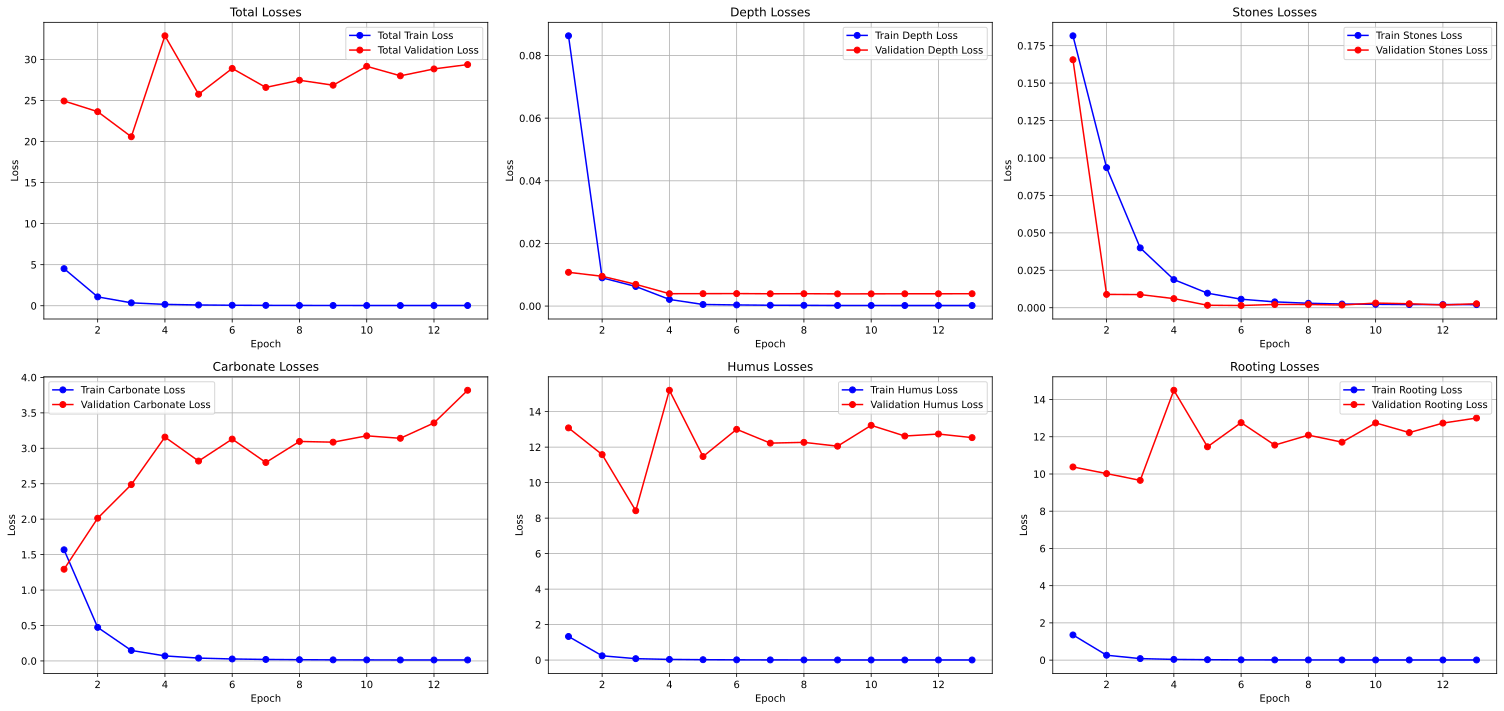

In [55]:
plt.figure(figsize=(21, 10))

complete_epochs = len(train_loss_history)+1
plt.subplot(2, 3, 1)
plt.plot(range(1, complete_epochs), train_loss_history, label='Total Train Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_loss_history,  label='Total Validation Loss',  marker='o', color='r')
plt.title('Total Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 3, 2)
plt.plot(range(1, complete_epochs), train_depth_loss_history, label='Train Depth Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_depth_loss_history,  label='Validation Depth Loss',  marker='o', color='r')
plt.title('Depth Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 3, 3)
plt.plot(range(1, complete_epochs), train_stones_loss_history, label='Train Stones Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_stones_loss_history,  label='Validation Stones Loss',  marker='o', color='r')
plt.title('Stones Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 3, 4)
plt.plot(range(1, complete_epochs), train_carb_loss_history, label='Train Carbonate Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_carb_loss_history,  label='Validation Carbonate Loss',  marker='o', color='r')
plt.title('Carbonate Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 3, 5)
plt.plot(range(1, complete_epochs), train_humus_loss_history, label='Train Humus Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_humus_loss_history,  label='Validation Humus Loss',  marker='o', color='r')
plt.title('Humus Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 3, 6)
plt.plot(range(1, complete_epochs), train_root_loss_history, label='Train Rooting Loss', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_root_loss_history,  label='Validation Rooting Loss',  marker='o', color='r')
plt.title('Rooting Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

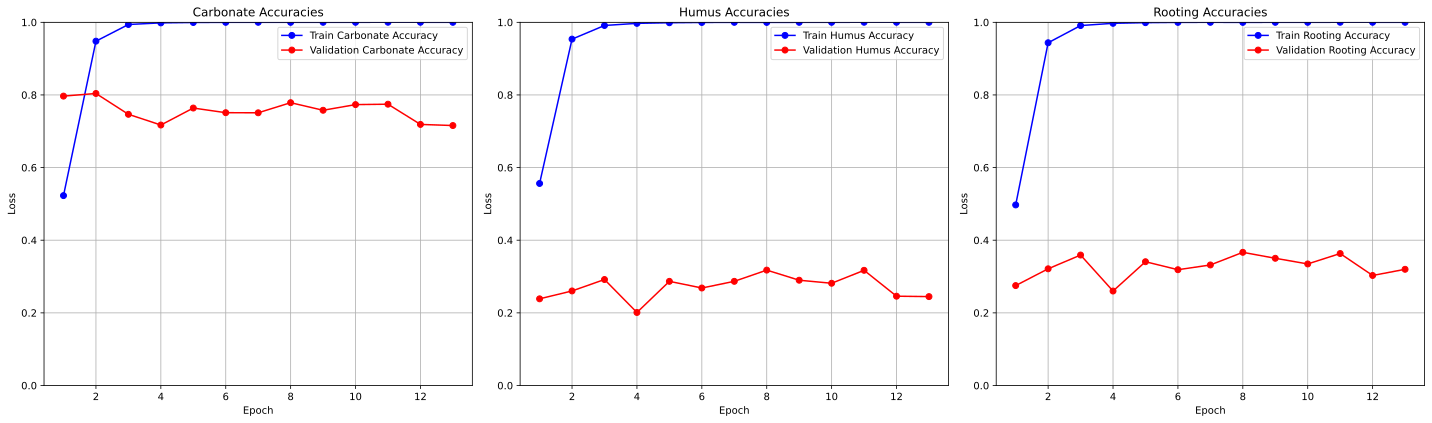

In [56]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1, complete_epochs), train_carb_acc_history, label='Train Carbonate Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_carb_acc_history,  label='Validation Carbonate Accuracy',  marker='o', color='r')
plt.title('Carbonate Accuracies')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.ylim([0.0, 1.0])
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(range(1, complete_epochs), train_humus_acc_history, label='Train Humus Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_humus_acc_history,  label='Validation Humus Accuracy',  marker='o', color='r')
plt.title('Humus Accuracies')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.ylim([0.0, 1.0])
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(range(1, complete_epochs), train_root_acc_history, label='Train Rooting Accuracy', marker='o', color='b')
plt.plot(range(1, complete_epochs), val_root_acc_history,  label='Validation Rooting Accuracy',  marker='o', color='r')
plt.title('Rooting Accuracies')
plt.xlabel('Epoch');plt.ylabel('Loss')
plt.ylim([0.0, 1.0])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

To complete after the model is able to predict horizon labels

In [ ]:
model.eval()  # Set the model again in inference mode
with torch.no_grad():
    outputs = []
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    for batch in val_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_probs, predicted_labels = [], []
for output in outputs:

    predicted_labels.extend(torch.argmax(output, dim=1).tolist())
    predicted_probs.extend(torch.softmax(output, dim=1).cpu().numpy()) # Convert logits to probabilities

# Convert true labels to a list
true_labels = [label.item() for batch in val_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

In [ ]:
# Compute PR curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)
n_classes = predicted_probs.shape[1]
precision, recall, avg_precision = {}, {}, {}
# Binarize the labels (one-hot encoding for multiclass)
true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    avg_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_probs[:, i])

# Compute macro-average PR curve
precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_binarized.ravel(), predicted_probs.ravel())
avg_precision["macro"] = average_precision_score(true_labels_binarized, predicted_probs, average="macro")

In [ ]:
plt.figure(figsize=(10, 8))

# Plot PR curves for each class
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.2f})')

# Plot macro-average PR curve
plt.plot(recall["macro"], precision["macro"], linestyle='--', lw=2, color='black',
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()